![SegmentLocal](animated.gif "segment")

This post discusses Particle Swarm Optimization (PSO), an optimization algorithm inspired by swarm intelligence. It is a versatile metaheuristic algorithm used for solving optimization problems.

In PSO, a group of particles explores the search space to find the best solution. Each particle represents a potential solution and is guided by its own best-known position as well as the overall best-known position among all particles in the group.

To demonstrate PSO in action, the [inspyred](https://pythonhosted.org/inspyred/index.html) library will be utilized throughout this notebook. This Python library offers a collection of pre-implemented bio-inspired algorithms.

In [1]:
!pip install inspyred

Defaulting to user installation because normal site-packages is not writeable


## Details of the implementation
The implementation includes the following steps. Firstly, all the necessary imports are included. Then, the original class `inspyred.swarm.PSO` is inherited to enable storing the complete evolution history of the population at each generation. This allows for the storage and visualization of all intermediate values when using Particle Swarm Optimization (PSO). However, in a real-world application of PSO, this additional storage can result in unnecessary overhead.

Lastly, the population in the search space is initialized using the `uniform_generator`, which uniformly distributes the particles based on a normal distribution. This generator function allows for the implementation of more complex initializers using Design of Experiments (DOE). By utilizing DOE, it is possible to identify the most influential factors, determine optimal settings, and reduce variability and costs.

In [2]:
import inspyred
import numpy as np
from inspyred import ec
from random import Random
from matplotlib import pyplot as plt
import collections
collections.Iterable = collections.abc.Iterable
collections.Sequence = collections.abc.Sequence

# This class inherits from the original inspyred.swarm.PSO class to store the
# evolution of the population at each generation
class PSO(inspyred.swarm.PSO):
  def _swarm_archiver(self, random, population, archive, args):
    self.swarm_archive.append(population)
    if len(archive) == 0:
      return population[:]
    else:
      new_archive = []
      for i, (p, a) in enumerate(zip(population[:], archive[:])):
        if p < a:
          new_archive.append(a)
        else:
          new_archive.append(p)
      return new_archive

# This function randomly initializes the particles in the search space based on
# a uniform distribution
def uniform_generator(random, args):
  return [
    random.uniform(
      args["bounds"][0], args["bounds"][1]
    ) for _ in range(args["num_vars"])
  ]

To facilitate the execution of PSO, the following function has been devised that handles the initialization of parameters and tracks the entire evolutionary history of each particle.

In [3]:
STAR = 'star'
RING = 'ring'

def run_pso(random, func, num_vars=2, maximize=False, **kwargs):
    
  algorithm = PSO(random)
  algorithm.swarm_archive = []
  algorithm.topology = inspyred.swarm.topologies.star_topology
  algorithm.terminator = ec.terminators.generation_termination
  
  if kwargs["topology"] is STAR:
    algorithm.topology = inspyred.swarm.topologies.star_topology
  elif kwargs["topology"] is RING:
    algorithm.topology = inspyred.swarm.topologies.ring_topology

  kwargs["num_selected"]=kwargs["pop_size"]
  kwargs["bounder"]= func.bounder()
  kwargs["generator"]=uniform_generator
  
  # Evolution step
  final_pop = algorithm.evolve(evaluator=func,  
                        maximize=maximize,
                        num_vars=num_vars,
                        **kwargs)

  # Reconstruct the whole history of the particles
  evolution_history = []
  for i in range(len(algorithm.swarm_archive)):
      evolution_history.append(
        [elem.candidate for elem in algorithm.swarm_archive[i]]
      )

  return evolution_history

To gain a comprehensive understanding of the evolution process, I have developed the function `plot_population_evolution`, which graphically represents the population at each generation. This function proves to be immensely valuable as it enables us to effectively visualize the convergence of the algorithm.

In [4]:
def plot_population_evolution(evolution_history, func, generation_step=1):
    plt.clf()
    resolution = 100
    fig, ax = plt.subplots(2, 3, constrained_layout=True)
    axf = ax.flatten()
    fig.set_figwidth(10.5)
    fig.set_figheight(7)

    bounds_lower = func.lower_bound
    bounds_upper = func.upper_bound
    x = np.linspace(bounds_lower, bounds_upper, resolution)
    y = np.linspace(bounds_lower, bounds_upper, resolution)
  
    X, Y = np.meshgrid(x, y)
    Z = np.asarray([[func.f((X[i][j], Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

    contourf = None
    for i in range(min(len(evolution_history), 6)):
        if i * generation_step < len(evolution_history):
            axf[i].contour(x, y, Z, levels=30, linewidths=0.5, colors="k")
            contourf = axf[i].contourf(x, y, Z, levels=30, cmap='viridis', vmin=Z.min(), vmax=Z.max(), alpha=0.9)
            axf[i].set_xlabel('x')
            axf[i].set_ylabel('y')
            axf[i].title.set_text("Generation " + str(i * generation_step))

            # scatter plot of the population
            current_pop = evolution_history[i * generation_step]
            xdata = [x[0] for x in current_pop]
            ydata = [x[1] for x in current_pop]
            axf[i].scatter(xdata, ydata, color="r", s=7, zorder=2, label="population")

    fig.colorbar(contourf, ax=ax[:,2], shrink=0.8, aspect=30)
    handles, labels = axf[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    plt.show()

## Particle Swarm Optimization


During each step of the Particle Swarm Optimization (PSO) algorithm, every particle updates its velocity and moves to a new position using the updated velocity, denoted as $v'$. If $x$ represents the current position of a particle at time $t$, then the new position of the same particle at time $t+1$, denoted as $x'$, is calculated as $x' = x + v'$. The velocity of the particle at time $t+1$, denoted as $v'$, for the particle $x$ is computed using the following equation:

$$
v' = w \cdot v + \phi_1 U_1 \cdot (y-x) + \phi_2 U_2 \cdot (z-x)
$$

where:
- $w$ represents the inertia weight, determining the influence of the previous velocity on the current velocity.
- $v$ is the velocity of the particle at time $t$.
- $x$ is the current position of the particle at time $t$.
- $z$ denotes the position of the particle with the best global solution found within the neighborhood of the current particle.
- $y$ represents the position of the best solution found by the current particle itself.
- $\phi_1$ is the cognitive rate, which regulates the personal influence of the particle.
- $\phi_2$ is the social rate, which regulates the social influence of the particle.
- $U_1$ and $U_2$ are two uniform random numbers.

By using these equations, the PSO algorithm updates the velocity and position of each particle in order to search for the optimal solution.


##### **The inertia**

The inertia parameter plays a crucial role in finding a balance between exploration and exploitation in Particle Swarm Optimization. When the inertia weight $w$ is set to 1, the particle's movement is solely influenced by its previous motion, causing it to continue in the same direction. Conversely, if $0 \leq w \leq 1$, the particle's trajectory is influenced by both personal and social factors, leading it to explore different directions within the search space. This adjustment allows for a trade-off between exploiting the current best position and exploring new areas of the solution space.



##### **Personal and Social influence factors**

The velocity equation in Particle Swarm Optimization is primarily influenced by two significant factors:
* The personal influence $\phi_1 U_1 \cdot (y-x)$: This factor accounts for the particle's attraction towards its own best point. As the particle moves farther away from its previous best position $y$, the magnitude of the personal factor increases, resulting in a stronger pull towards the particle's personal best.
* The social influence $\phi_2 U_2 \cdot (z-x)$: This factor represents the particle's attraction towards the best positions of other particles. It enables the particle to be influenced by the collective knowledge of the swarm, as it seeks to move closer to the best positions found by its neighboring particles.

These two influencing factors contribute to the overall velocity of the particle and play a vital role in guiding its movement towards better solutions during the optimization process.



##### **Neighborhood Topologies**

Regarding the parameter $z$, which represents the position of the particle with the best value within the neighborhood of the current particle, there are two different topology options to consider:

1. *Star topology*: In this topology, each particle in the population is considered a neighbor of the current particle, similar to a fully connected graph. All particles' best positions within the entire population are taken into account when determining the influence of the social factor.

2. *Ring topology*: In this topology, each particle is connected to a specific number of neighbors, defined as the `neighborhood_size`. The neighborhood size determines how many neighboring particles influence the social factor. Each particle only considers the best position of its specific set of neighbors when calculating the social influence.



## Benchmark functions


To simplify the process, the `OptimizationFunction` class has been designed to enable the creation of custom functions for optimization purposes. When creating a class that inherits from this base class, the user is expected to implement the `def f(self, x0)` function. This function should contain the actual implementation of the benchmark function being considered for optimization. By following this approach, the user can easily define and utilize it's own specific functions within the optimization framework.

In [5]:
class OptimizationFunction():

  def __init__(self, name, lower_bound, upper_bound):
    self.lower_bound = lower_bound
    self.upper_bound = upper_bound
    self.__name__ = name

  def f(self, x0):  # To be implemented
    print("Override 'def f(self, x0)' function")

  def __call__(self, candidates, *args, **kwargs):
    y = []
    for x0 in candidates:
      y.append(self.f(x0))
    return y

  def bounds(self):
    return [(self.lower_bound, self.upper_bound), (self.lower_bound, self.upper_bound)]

  def bounder(self):
    def fcn(candidate, *args):
      if candidate[0] < self.lower_bound:
        candidate[0] = self.lower_bound
      if candidate[1] < self.lower_bound:
        candidate[1] = self.lower_bound
      if candidate[1] > self.upper_bound:
        candidate[1] = self.upper_bound
      if candidate[0] > self.upper_bound:
        candidate[0] = self.upper_bound

      return candidate
    return fcn

Below is the implementation of commonly used benchmark functions for optimization.

In [6]:
class StyblinskiTang(OptimizationFunction):

  def __init__(self, lower_bound, upper_bound):
    super().__init__('Styblinski-Tang', lower_bound, upper_bound)

  def f(self, x0):
    x = x0[0]
    y = x0[1]
    term1 = x**4 - 16*x**2 + 5*x
    term2 = y**4 - 16*y**2 + 5*y
    return 0.5 * (term1 + term2)

In [7]:
class Himmelblau(OptimizationFunction):

  def __init__(self, lower_bound, upper_bound):
    super().__init__('Himmelblau', lower_bound, upper_bound)

  def f(self, x0):
    x = x0[0]
    y = x0[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [8]:
class Rosenbrock(OptimizationFunction):

  def __init__(self, lower_bound, upper_bound):
    super().__init__('Rosenbrock', lower_bound, upper_bound)

  def f(self, x0):
    x = x0[0]
    y = x0[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

In [9]:
class Rastrigin(OptimizationFunction):

  def __init__(self, lower_bound, upper_bound):
    super().__init__('Rastrigin', lower_bound, upper_bound)

  def f(self, x0):
    x = x0[0]
    y = x0[1]
    return 20 + x**2 - 10 * np.cos(2 * np.pi * x) + y**2 - 10 * np.cos(2 * np.pi * y)

## Visualization

This section displays visualizations depicting the algorithm's progress over various parameter configurations and optimization functions. In the code block provided, the common arguments shared among all the tests are defined. These arguments include setting the population to 50 individuals and the total number of generations to 100. It is important to note that these numbers are chosen for demonstration purposes, and in some cases, not all 100 generations are plotted.

In [10]:
args = {} 
args["num_vars"] = 2              # Number of dimensions of the search space
args["pop_size"] = 50             # Number of particles
args["max_generations"] = 100     # Total number of generations of the algorithm
args["inertia"] = 0.2             # The inertia of each particle

#### **Himmelblau**

The following test employs a star topology for the particles, with a greater emphasis on the social influence factor. It is evident that the social influence dominates, as the particles gradually converge towards the same minimum over several generations.

<Figure size 640x480 with 0 Axes>

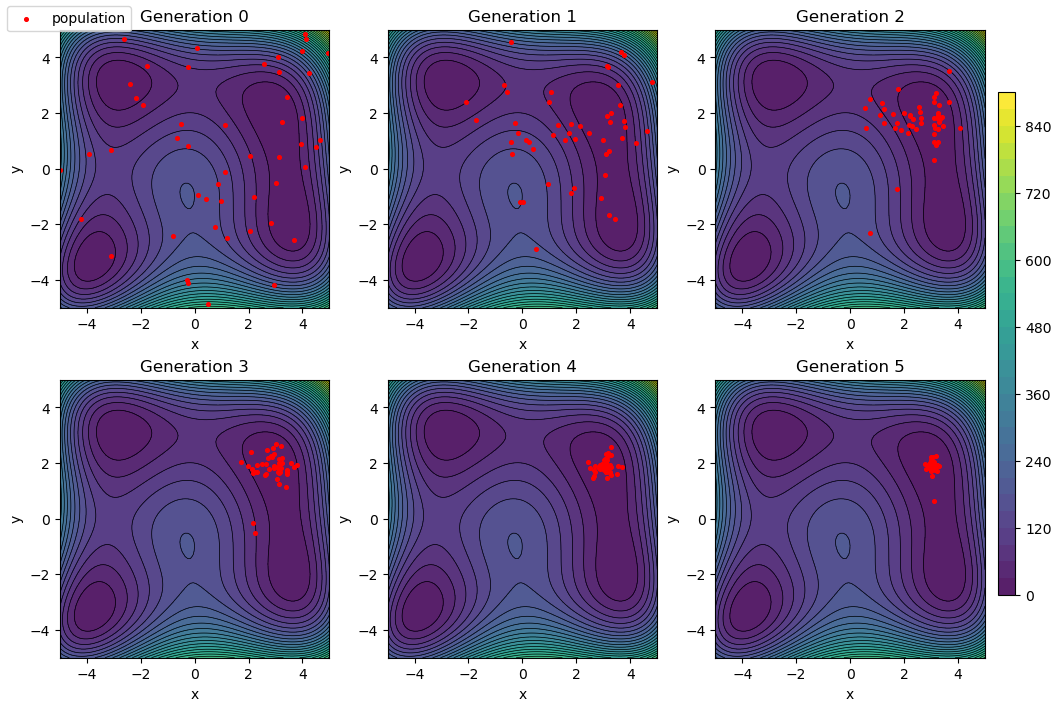

In [11]:
func = Himmelblau(-5, 5)
args["bounds"] = func.bounds()[0] 

args["topology"] = STAR
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.9

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=1)

The complementary case, however, reveals a different scenario where certain particles attract others towards completely different minima. Specifically, when considering the Himmelblau function with its four minima, it can be observed that the particles in the exhibit divergent behavior, dispersing across the search space and converging towards separate minima.

<Figure size 640x480 with 0 Axes>

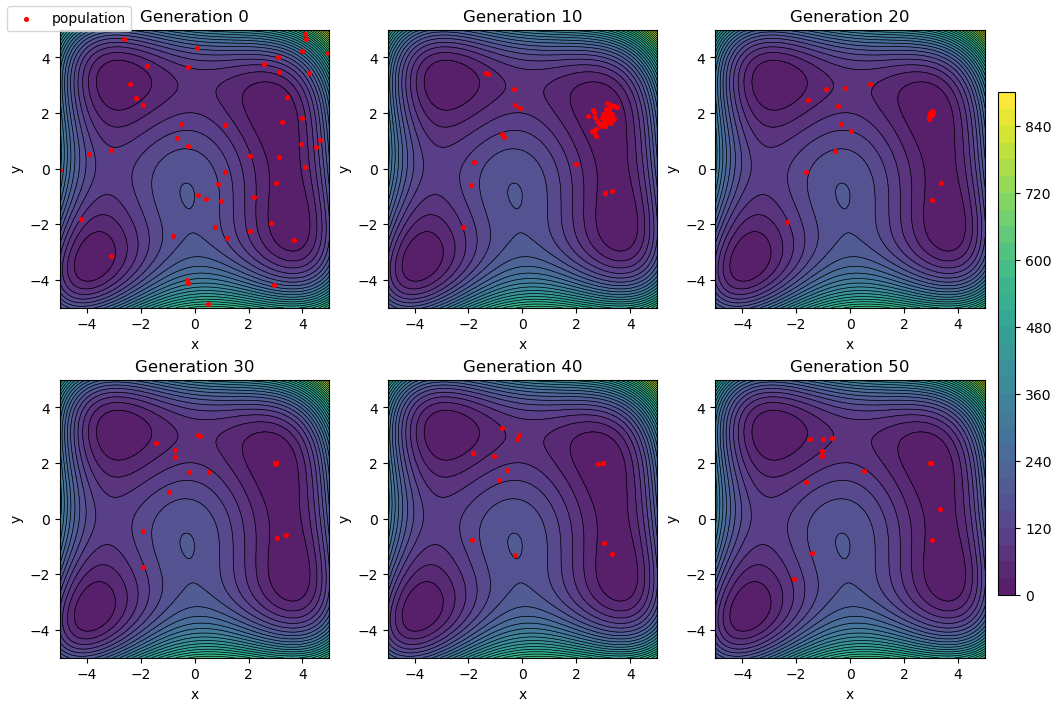

In [12]:
func = Himmelblau(-5, 5)
args["bounds"] = func.bounds()[0] 

args["topology"] = STAR
args["cognitive_rate"] = 0.9
args["social_rate"] = 0.3

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=10)

By employing a ring topology where each particle is influenced solely by its two neighboring particles, a remarkably similar outcome can be observed.

<Figure size 640x480 with 0 Axes>

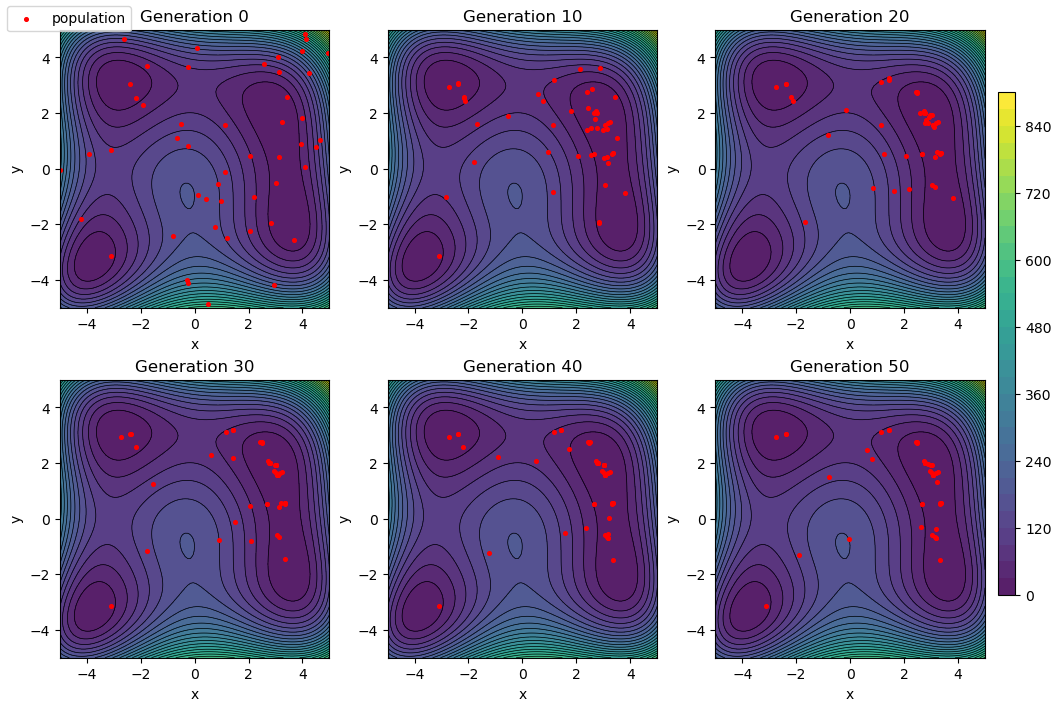

In [13]:
func = Himmelblau(-5, 5)
args["bounds"] = func.bounds()[0] 

args["topology"] = RING
args["neighborhood_size"] = 2   # used only for the ring topology
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.6

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=10)

#### **Styblinski-Tang**

When optimizing the Styblinski-Tang function, a similar phenomenon as previously observed can be noticed, where the social influence factor causes the particles to converge towards the same minimum.

<Figure size 640x480 with 0 Axes>

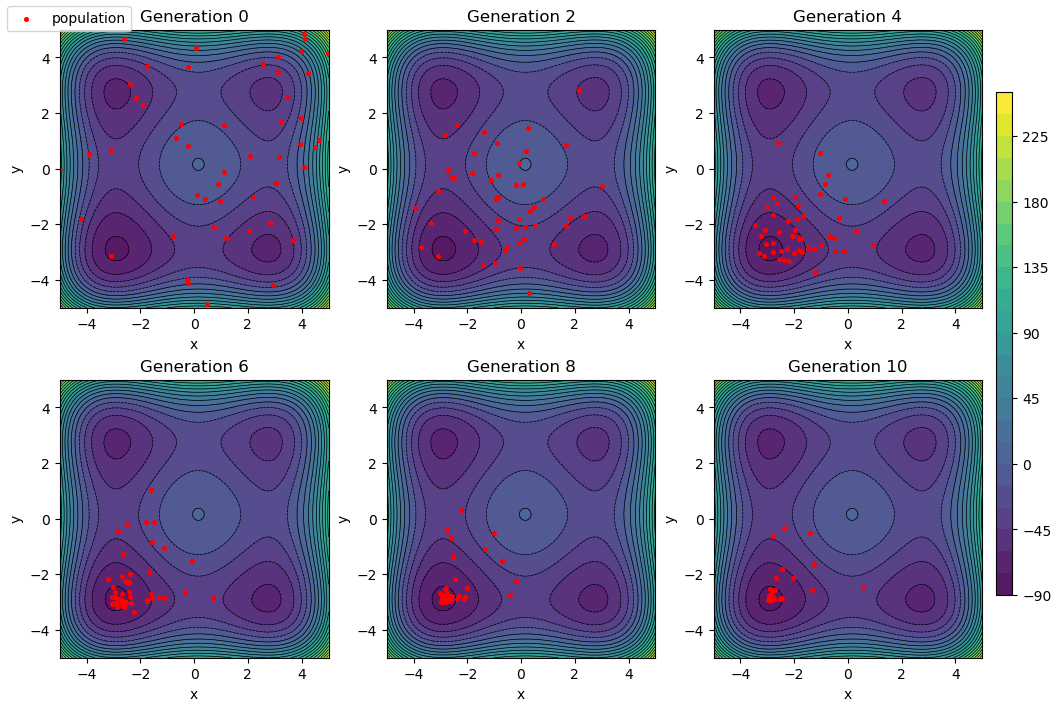

In [14]:
func = StyblinskiTang(-5, 5)
args["bounds"] = func.bounds()[0] 

args["topology"] = STAR
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.5

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=2)

The use of the ring topology in the algorithm highlights its inclination towards exploration rather than exploitation. This means that the algorithm prioritizes searching the solution space extensively rather than focusing solely on exploiting known promising areas. As a result, after a few iterations, it becomes evident that while some particles successfully converge towards the global minimum, others become trapped in the basin of attraction associated with different local minima.

<Figure size 640x480 with 0 Axes>

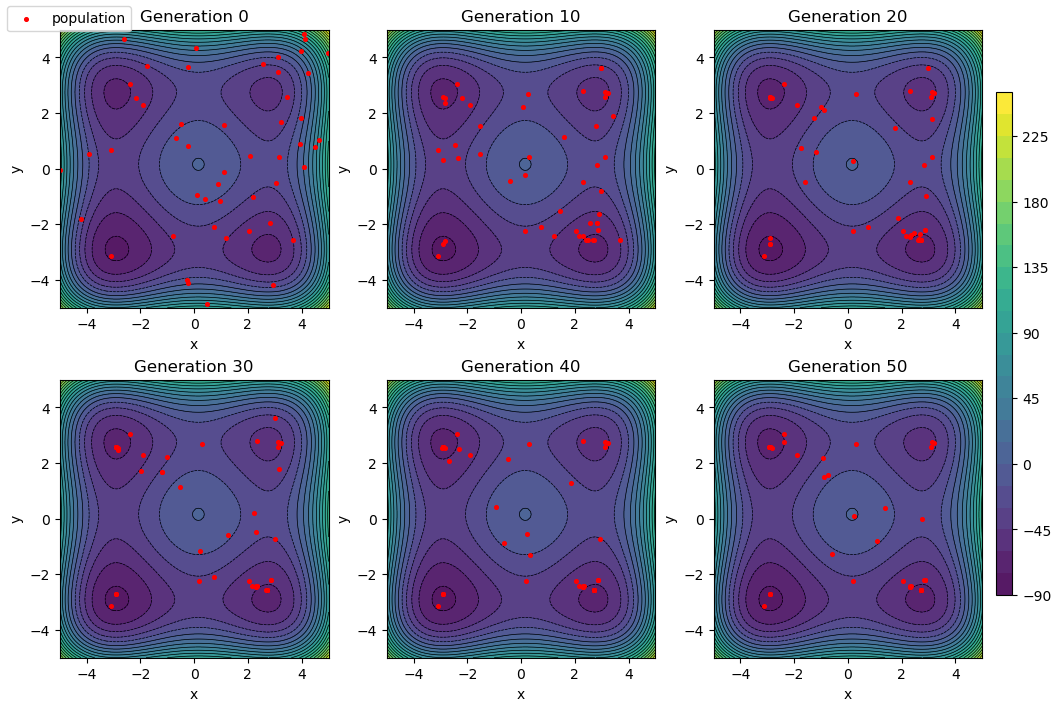

In [15]:
func = StyblinskiTang(-5, 5)
args["bounds"] = func.bounds()[0] 

args["topology"] = RING
args["neighborhood_size"] = 2   # used only for the ring topology
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.6

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=10)

#### **Rastrigin**

This scenario represents a non-convex and highly multimodal function, which demonstrates the particles' capability to evade becoming trapped in a single basin of attraction among the numerous ones present. It is noteworthy that, even in this case, the topology employed played a pivotal role. Specifically, when using the star topology, the influence of each particle enabled them all to avoid getting trapped in the same basin of attraction. On the other hand, when utilizing the ring topology, the same behavior as before is observed, where particles reach different basins of attraction and remain stuck in them.

<Figure size 640x480 with 0 Axes>

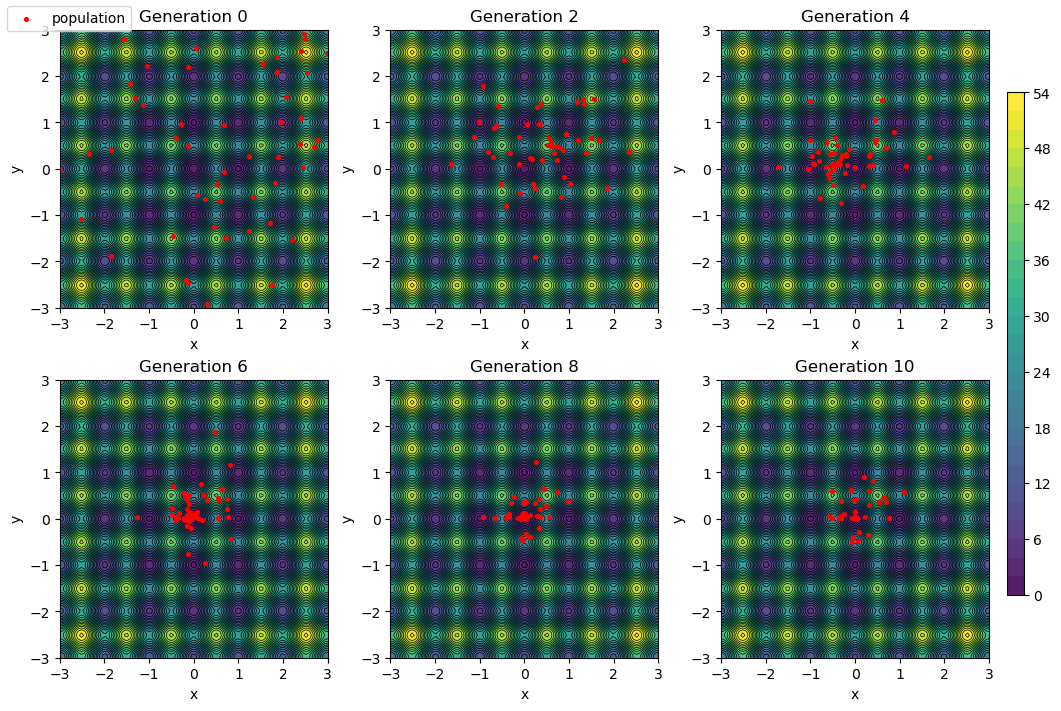

In [16]:
func = Rastrigin(-3, 3)
args["bounds"] = func.bounds()[0] 

args["topology"] = STAR
args["cognitive_rate"] = 0.5
args["social_rate"] = 0.6

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=2)

<Figure size 640x480 with 0 Axes>

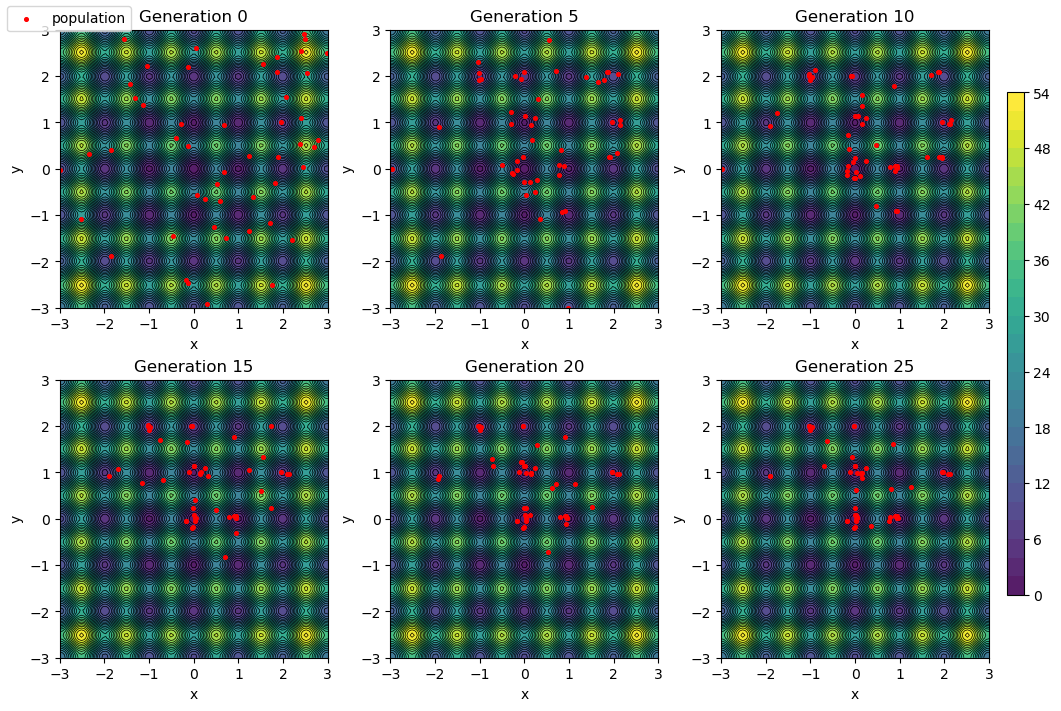

In [17]:
func = Rastrigin(-3, 3)
args["bounds"] = func.bounds()[0] 

args["topology"] = RING
args["neighborhood_size"] = 2   # used only for the ring topology
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.9

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=5)

#### **Rosenbrock**

To ensure comprehensive coverage, the results obtained on the Rosenbrock function are also presented. This function is non-convex, unimodal, and poses a challenge in approximating its global minimum.

<Figure size 640x480 with 0 Axes>

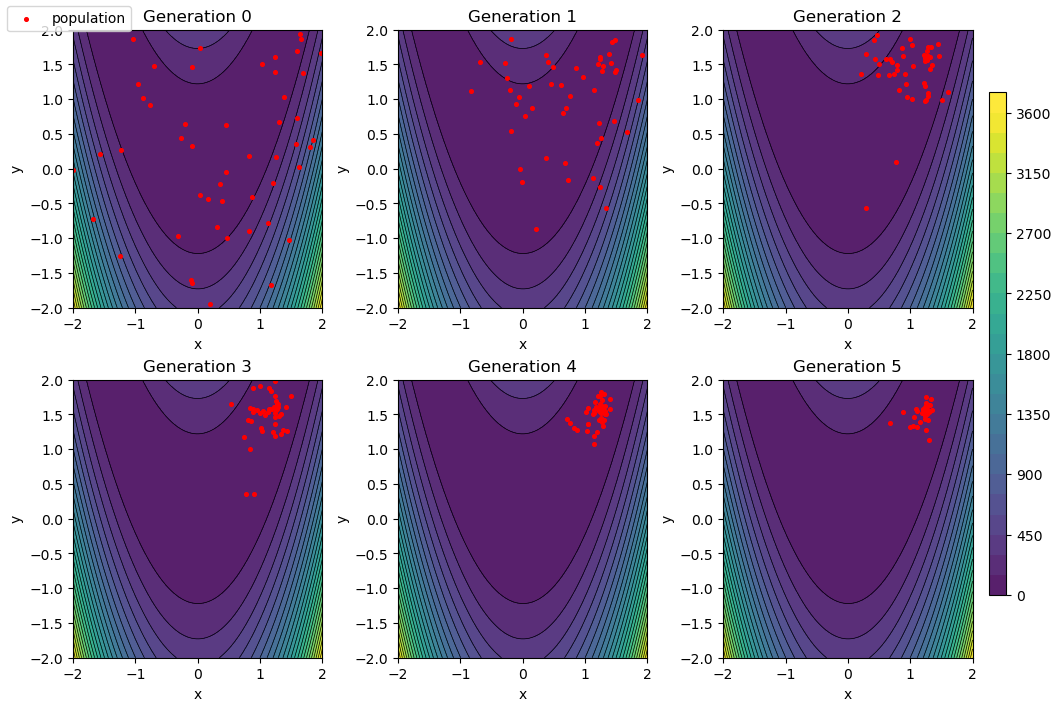

In [20]:
func = Rosenbrock(-2, 2)
args["bounds"] = func.bounds()[0] 

args["topology"] = STAR
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.9

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=1)

<Figure size 640x480 with 0 Axes>

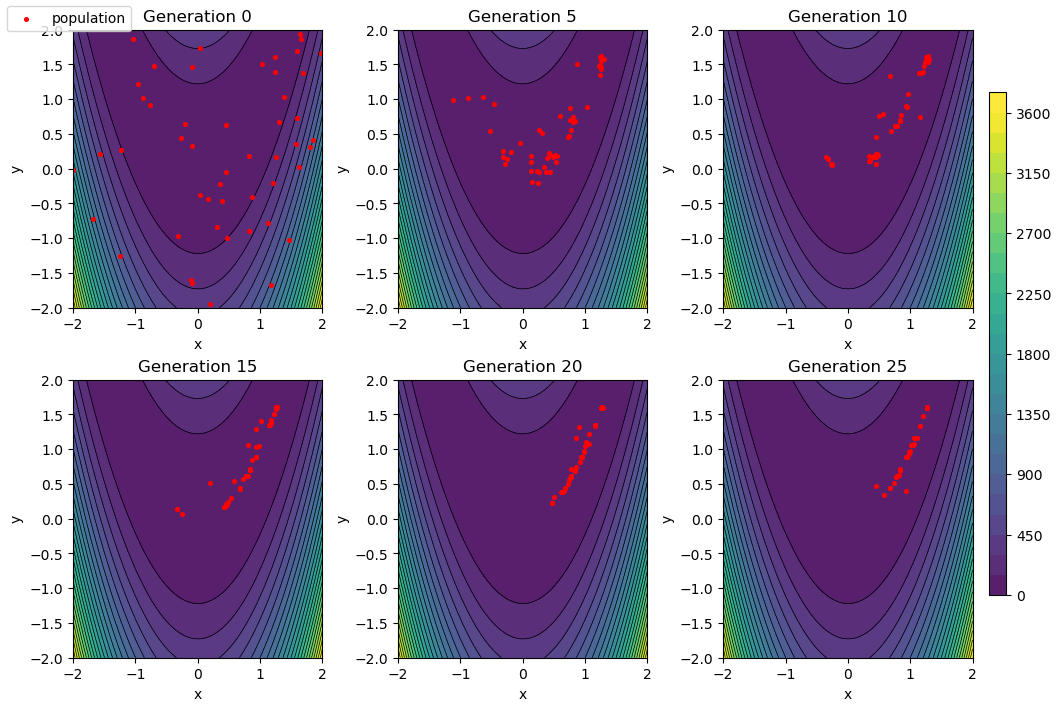

In [19]:
func = Rosenbrock(-2, 2)
args["bounds"] = func.bounds()[0] 

args["topology"] = RING
args["neighborhood_size"] = 3   # used only for the ring topology
args["cognitive_rate"] = 0.3
args["social_rate"] = 0.9

evolution_history = run_pso(Random(0), func, **args)
plot_population_evolution(evolution_history, func, generation_step=5)

## Conclusions

This post explored Particle Swarm Optimization as a versatile metaheuristic algorithm for solving optimization problems. It discussed the concepts of PSO, including it's main equation for particle movement, the role of inertia, and the influence of personal and social factors. The post also presented different neighborhood topologies, namely star and ring topologies, and their impact on the algorithm's behavior.

The post presented the showcased outcomes achieved by applying PSO to various benchmark functions, emphasizing the visual representation of how particle swarm optimization operates. The results provided insights into the impact of different parameter settings on the behavior and effectiveness of the PSO algorithm across diverse optimization scenarios. This understanding equips practitioners with the knowledge necessary to apply PSO effectively in solving a broad spectrum of optimization problems.

## References

1. Kennedy, J., & Eberhart, R. (1995). Particle swarm optimization. In Proceedings of ICNN'95 - International Conference on Neural Networks (Vol. 4, pp. 1942-1948). IEEE.
2. Martins, J. R. R. A., & Ning, A. (2022). Engineering Design Optimization. Cambridge University Press.
3. inspyred: Bio-inspired Algorithms in Python. Retrieved from [https://pythonhosted.org/inspyred/](https://pythonhosted.org/inspyred)
